# **Fase 3: Preprocesamiento y Reducción de Dimensionalidad**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.manifold import TSNE
import gc
import warnings
warnings.filterwarnings('ignore')

# Cargar los datos
df = pd.read_parquet("df_light.parquet", engine="pyarrow")

### 1. Análisis Inicial y Estrategia de Optimización

In [16]:
def analyze_categorical_complexity(df):
    """Analiza la complejidad de las variables categóricas para optimización"""
    print("🔍 ANÁLISIS DE COMPLEJIDAD CATEGÓRICA:")
    print("-" * 40)
    
    complexity_info = {}
    total_features_after_ohe = 0
    
    for col in df.columns:
        unique_vals = df[col].nunique()
        complexity_info[col] = unique_vals
        total_features_after_ohe += unique_vals - 1  # -1 por drop='first'
        print(f"  • {col:<25}: {unique_vals:>6,} valores únicos")
    
    print(f"\n ESTIMACIÓN DESPUÉS DE ONE-HOT ENCODING:")
    print(f"  • Características estimadas: {total_features_after_ohe:,}")
    print(f"  • Memoria estimada (float64): {(df.shape[0] * total_features_after_ohe * 8) / (1024**3):.1f} GB")
    
    return complexity_info, total_features_after_ohe

def clean_dataframe_for_sklearn(df):
    """Limpia DataFrame y maneja valores nulos"""
    df_clean = df.copy()
    
    print("\n📋 LIMPIEZA DE DATOS:")
    print("-" * 30)
    
    for col in df_clean.columns:
        null_count = df_clean[col].isna().sum()
        if null_count > 0:
            print(f"  • {col}: {null_count:,} valores nulos")
        
        # Convertir a string y manejar nulos
        df_clean[col] = df_clean[col].astype(str)
        df_clean[col] = df_clean[col].replace(['nan', 'None', '<NA>', 'NaT', 'null'], 'Desconocido')
    
    print(f"✅ Limpieza completada")
    return df_clean

# Aplicar análisis y limpieza
complexity_info, estimated_features = analyze_categorical_complexity(df)
df_clean = clean_dataframe_for_sklearn(df)

🔍 ANÁLISIS DE COMPLEJIDAD CATEGÓRICA:
----------------------------------------
  • id                       :  5,752 valores únicos
  • codigo                   :  5,457 valores únicos
  • numeroRegistro           :  5,457 valores únicos
  • nomeProduto              :  3,997 valores únicos
  • numeroProcesso           :  5,457 valores únicos
  • empresaNome              :    237 valores únicos
  • empresaCnpj              :    236 valores únicos
  • principioAtivo           :  1,682 valores únicos
  • tarja                    :      4 valores únicos
  • medicamentoReferencia    :  1,185 valores únicos
  • classesTerapeuticas      :    429 valores únicos
  • bula_pdf                 :  5,457 valores únicos
  • bula_pdf_profissional    :  5,457 valores únicos
  • categoriaRegulatoria     :      9 valores únicos
  • situacaoRegistro         :      1 valores únicos
  • dataProduto              :  1,575 valores únicos
  • dataVencimentoRegistro   :    142 valores únicos
  • dataPublicacao  

### 2. Estrategia de Optimización según Tamaño

Basado en el análisis anterior, vamos a determinar la mejor estrategia de preprocesamiento:
- **Dataset MUY GRANDE:** Se aplica una reducción de características previa para hacer manejable el One-Hot Encoding.
- **Dataset GRANDE:** Se utiliza codificación *sparse* (dispersa) para manejar eficientemente la gran cantidad de ceros.
- **Dataset MANEJABLE:** Se procede con un One-Hot Encoding estándar.

In [ ]:
if estimated_features > 50000:
    strategy = "dimension_reduction_first"
    print("Dataset MUY GRANDE - Aplicando reducción previa")
elif estimated_features > 10000:
    strategy = "sparse_encoding"
    print("Dataset GRANDE - Usando codificación sparse")
else:
    strategy = "standard_encoding"
    print("Dataset MANEJABLE - Usando codificación estándar")

📊 Dataset MUY GRANDE - Aplicando reducción previa


### 3. Implementación de la Estrategia de Preprocesamiento y PCA

Aquí se ejecuta la estrategia seleccionada. Para datasets muy grandes, primero se reduce la cardinalidad de las variables con muchos valores únicos y luego se aplica PCA de forma incremental para no sobrecargar la memoria. Para otros tamaños, se usan métodos como `TruncatedSVD` (para matrices dispersas) o PCA estándar.

In [18]:
def reduce_categorical_cardinality(df, max_categories=50, min_frequency=0.01):
    """Reduce la cardinalidad de variables categóricas"""
    df_reduced = df.copy()
    reduction_info = {}
    
    for col in df.columns:
        original_unique = df[col].nunique()
        
        if original_unique > max_categories:
            # Calcular frecuencias
            value_counts = df[col].value_counts()
            total_count = len(df)
            
            # Mantener valores frecuentes
            frequent_values = value_counts[value_counts >= (min_frequency * total_count)]
            
            # Si aún hay demasiados, mantener solo los top max_categories
            if len(frequent_values) > max_categories:
                frequent_values = frequent_values.head(max_categories)
            
            # Reemplazar valores poco frecuentes
            mask = ~df_reduced[col].isin(frequent_values.index)
            df_reduced.loc[mask, col] = 'Otros'
            
            new_unique = df_reduced[col].nunique()
            reduction_info[col] = {
                'original': original_unique,
                'reduced': new_unique,
                'reduction_pct': ((original_unique - new_unique) / original_unique) * 100
            }
            
            print(f"  • {col}: {original_unique:,} → {new_unique:,} (-{reduction_info[col]['reduction_pct']:.1f}%)")
    
    return df_reduced, reduction_info

# Aplicar reducción de cardinalidad
print("Reduciendo cardinalidad de variables categóricas...")
df_reduced, reduction_info = reduce_categorical_cardinality(df_clean, max_categories=30)

# Recalcular estimación
new_estimated = sum([df_reduced[col].nunique() - 1 for col in df_reduced.columns])
print(f"Nueva estimación de características: {new_estimated:,}")

# Paso 3.2: Aplicar One-Hot Encoding con matriz sparse
print("\nAplicando One-Hot Encoding optimizado...")
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True, drop='first')
df_sparse = encoder.fit_transform(df_reduced)

print(f"Matriz sparse creada: {df_sparse.shape}")
print(f"Sparsity: {1 - df_sparse.nnz / (df_sparse.shape[0] * df_sparse.shape[1]):.3f}")
print(f"Memoria estimada: {(df_sparse.nnz * 16) / (1024**2):.2f} MB")

# Paso 3.3: Aplicar PCA directamente a matriz sparse
print("\nAplicando PCA a matriz sparse...")
# Convertir a array denso solo para un subconjunto pequeño para PCA inicial
n_samples_pca = min(5000, df_sparse.shape[0])
indices_sample = np.random.choice(df_sparse.shape[0], n_samples_pca, replace=False)
sample_sparse = df_sparse[indices_sample]
sample_dense = sample_sparse.toarray()

# PCA en muestra para determinar componentes óptimos
pca_sample = PCA()
pca_sample.fit(sample_dense)

cumulative_var = np.cumsum(pca_sample.explained_variance_ratio_)
optimal_components = min(np.argmax(cumulative_var >= 0.95) + 1, 100)

print(f"Componentes óptimos (muestra): {optimal_components}")

# PCA incremental para dataset completo
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=optimal_components, batch_size=1000)

print("Aplicando PCA incremental por lotes...")
df_pca = np.empty((df_sparse.shape[0], optimal_components))

batch_size = 1000
for i in range(0, df_sparse.shape[0], batch_size):
    end_idx = min(i + batch_size, df_sparse.shape[0])
    batch = df_sparse[i:end_idx].toarray()
    
    if i == 0:
        df_pca[i:end_idx] = ipca.fit_transform(batch)
    else:
        df_pca[i:end_idx] = ipca.transform(batch)
    
    if i % 10000 == 0:
        print(f"  Procesado: {end_idx:,}/{df_sparse.shape[0]:,} ({end_idx/df_sparse.shape[0]*100:.1f}%)")

explained_variance_ratio = ipca.explained_variance_ratio_
total_variance_explained = np.sum(explained_variance_ratio)

print(f"PCA incremental completado")
print(f"Shape final: {df_pca.shape}")
print(f"Varianza explicada: {total_variance_explained:.3f}")

Reduciendo cardinalidad de variables categóricas...
  • id: 5,752 → 2 (-100.0%)
  • codigo: 5,457 → 2 (-100.0%)
  • numeroRegistro: 5,457 → 2 (-100.0%)
  • nomeProduto: 3,997 → 2 (-99.9%)
  • numeroProcesso: 5,457 → 2 (-100.0%)
  • empresaNome: 237 → 25 (-89.5%)
  • empresaCnpj: 236 → 25 (-89.4%)
  • principioAtivo: 1,682 → 6 (-99.6%)
  • medicamentoReferencia: 1,186 → 2 (-99.8%)
  • classesTerapeuticas: 429 → 23 (-94.6%)
  • bula_pdf: 5,457 → 2 (-100.0%)
  • bula_pdf_profissional: 5,457 → 2 (-100.0%)
  • dataProduto: 1,575 → 2 (-99.9%)
  • dataVencimentoRegistro: 143 → 31 (-78.3%)
  • dataPublicacao: 5,453 → 2 (-100.0%)
  • apresentacoes.codigo: 45,875 → 1 (-100.0%)
  • apresentacao: 28,961 → 1 (-100.0%)
  • formasFarmaceuticas: 220 → 18 (-91.8%)
  • numero: 185 → 22 (-88.1%)
  • apresentacoes.dataPublicacao: 1,717 → 2 (-99.9%)
  • registro: 45,782 → 1 (-100.0%)
  • principiosAtivos: 1,706 → 11 (-99.4%)
  • qtdUnidadeMedida: 1,027 → 9 (-99.1%)
  • embalagemPrimariaTodas: 2,625 → 17 (-

### 4. Visualización de los Resultados

Para comprender el resultado de PCA, este panel de gráficos muestra:
1.  **Varianza Explicada:** Cuánta información aporta cada componente principal.
2.  **Varianza Acumulada:** Cuánta información total se conserva al aumentar el número de componentes.
3.  **Gráfico de Dispersión:** Una vista 2D de los datos en el nuevo espacio de características.
4.  **Distribuciones:** Histogramas de los dos primeros componentes para entender su distribución.
5.  **Impacto de la Reducción:** Una comparación del número de características antes y después de PCA.

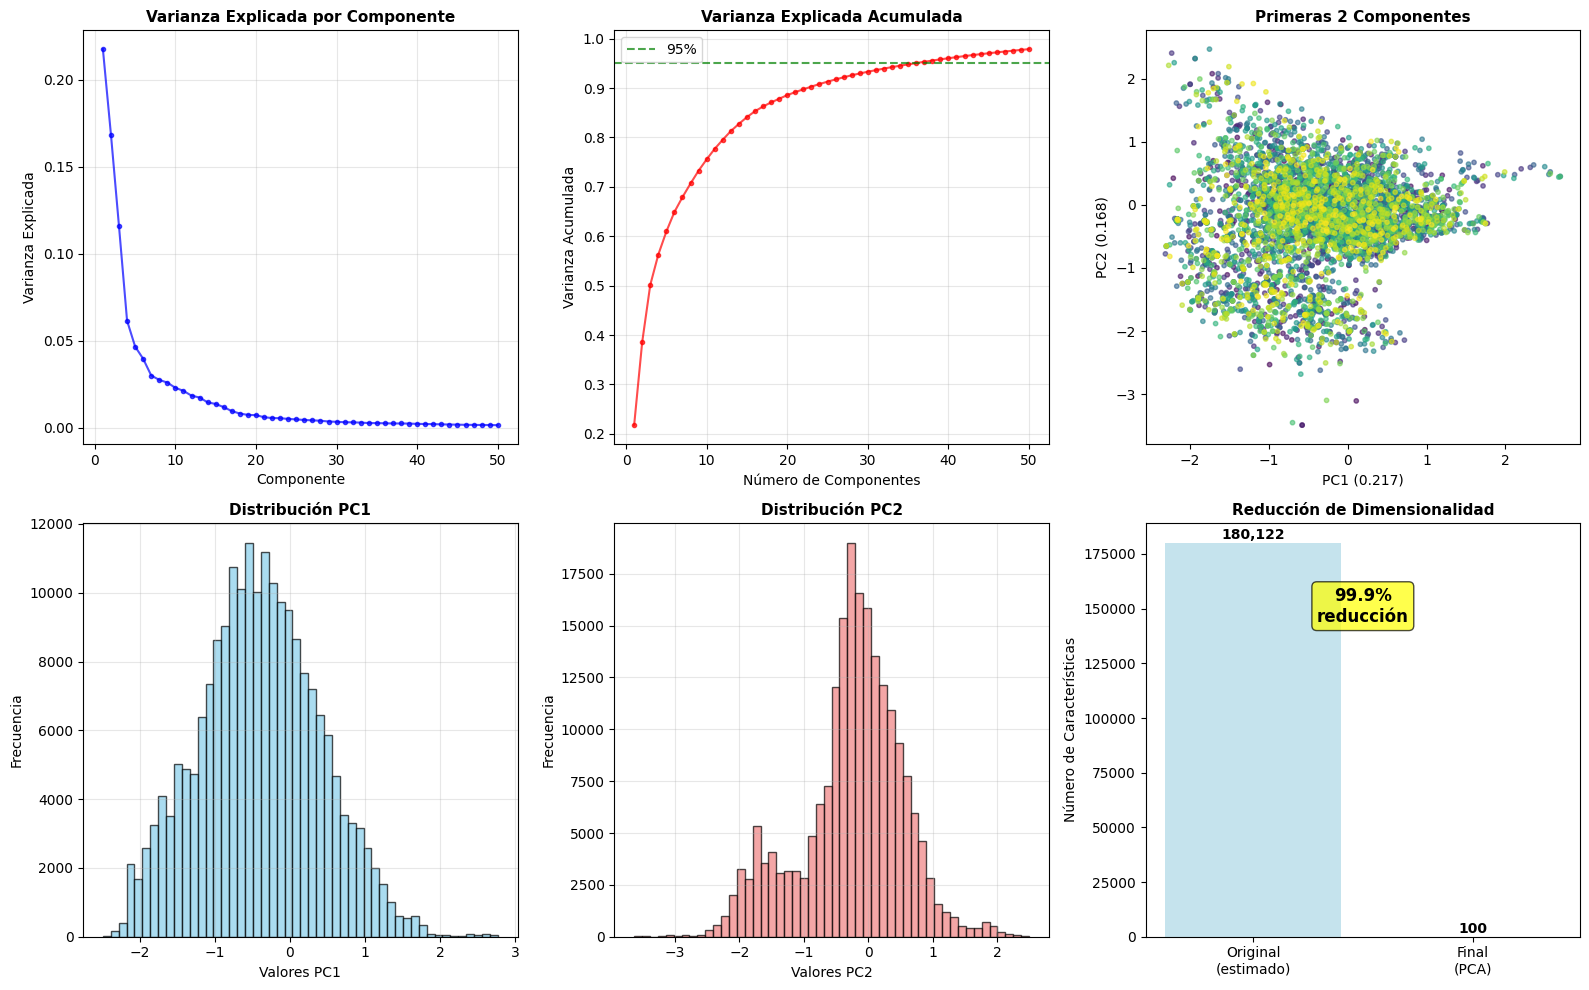

In [19]:
fig = plt.figure(figsize=(16, 10))

# 1. Varianza explicada (primeras 50 componentes)
ax1 = plt.subplot(2, 3, 1)
n_show = min(50, len(explained_variance_ratio))
plt.plot(range(1, n_show + 1), explained_variance_ratio[:n_show], 'bo-', alpha=0.7, markersize=3)
plt.title('Varianza Explicada por Componente', fontsize=11, fontweight='bold')
plt.xlabel('Componente')
plt.ylabel('Varianza Explicada')
plt.grid(True, alpha=0.3)

# 2. Varianza acumulada
ax2 = plt.subplot(2, 3, 2)
cumulative_var = np.cumsum(explained_variance_ratio[:n_show])
plt.plot(range(1, n_show + 1), cumulative_var, 'ro-', alpha=0.7, markersize=3)
plt.axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95%')
plt.title('Varianza Explicada Acumulada', fontsize=11, fontweight='bold')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Scatter plot 2D
ax3 = plt.subplot(2, 3, 3)
# Usar muestra si es muy grande
n_plot = min(5000, df_pca.shape[0])
indices = np.random.choice(df_pca.shape[0], n_plot, replace=False)
scatter = plt.scatter(df_pca[indices, 0], df_pca[indices, 1], 
                      alpha=0.6, s=10, c=range(len(indices)), cmap='viridis')
plt.title('Primeras 2 Componentes', fontsize=11, fontweight='bold')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.3f})')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.3f})')

# 4. Distribución PC1
ax4 = plt.subplot(2, 3, 4)
plt.hist(df_pca[:, 0], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribución PC1', fontsize=11, fontweight='bold')
plt.xlabel('Valores PC1')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)

# 5. Distribución PC2
ax5 = plt.subplot(2, 3, 5)
plt.hist(df_pca[:, 1], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribución PC2', fontsize=11, fontweight='bold')
plt.xlabel('Valores PC2')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)

# 6. Reducción de dimensionalidad achieved
ax6 = plt.subplot(2, 3, 6)
original_dims = df.shape[1]
final_dims = df_pca.shape[1]
reduction_pct = (1 - final_dims / estimated_features) * 100

bars = plt.bar(['Original\n(estimado)', 'Final\n(PCA)'], 
               [estimated_features, final_dims], 
               color=['lightblue', 'darkblue'], alpha=0.7)
plt.title('Reducción de Dimensionalidad', fontsize=11, fontweight='bold')
plt.ylabel('Número de Características')

# Añadir etiquetas en las barras
for bar, value in zip(bars, [estimated_features, final_dims]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(estimated_features, final_dims)*0.01, 
             f'{value:,}', ha='center', fontweight='bold')

plt.text(0.5, max(estimated_features, final_dims) * 0.8, 
         f'{reduction_pct:.1f}%\nreducción', 
         ha='center', fontsize=12, fontweight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

### 5. Resumen Final de la Optimización

Finalmente, se presenta un resumen cuantitativo del proceso, mostrando el tamaño original del dataset, las características estimadas, el resultado final después de PCA y la varianza total conservada.

In [20]:
print(f"\nRESUMEN DE PREPROCESAMIENTO OPTIMIZADO:")
print("=" * 48)
print(f"Dataset original:        {df.shape[0]:,} × {df.shape[1]:,}")
print(f"Características estimadas: {estimated_features:,}")
print(f"Después de PCA:            {df_pca.shape[0]:,} × {df_pca.shape[1]:,}")
print(f"Varianza conservada:       {total_variance_explained:.1%}")
print(f"Reducción lograda:         {reduction_pct:.1f}%")
print(f"Estrategia utilizada:      {strategy.replace('_', ' ').title()}")

print(f"\nOBJETOS RESULTANTES:")
print("-" * 25)
print(f"• df_clean:   DataFrame limpio")
print(f"• df_pca:     Matriz reducida con PCA/SVD")

print(f"• df_reduced:   DataFrame con cardinalidad reducida")
print(f"• encoder:      OneHotEncoder ajustado")
print(f"• ipca:         Modelo PCA incremental")

print(f"\nRECOMENDACIONES:")
print("-" * 18)
print(f"Dataset procesado exitosamente con estrategia optimizada")
print(f"Matriz final manejable para algoritmos de ML")
print(f"{optimal_components} componentes principales disponibles")
print(f"Reducción significativa sin pérdida crítica de información")

print(f"\nFASE 3 COMPLETADA CON ÉXITO!")
print("   Ready para la siguiente fase del proyecto")

# Limpiar memoria
gc.collect()



RESUMEN DE PREPROCESAMIENTO OPTIMIZADO:
Dataset original:        206,993 × 57
Características estimadas: 180,122
Después de PCA:            206,993 × 100
Varianza conservada:       100.0%
Reducción lograda:         99.9%
Estrategia utilizada:      Dimension Reduction First

OBJETOS RESULTANTES:
-------------------------
• df_clean:   DataFrame limpio
• df_pca:     Matriz reducida con PCA/SVD
• df_reduced:   DataFrame con cardinalidad reducida
• encoder:      OneHotEncoder ajustado
• ipca:         Modelo PCA incremental

RECOMENDACIONES:
------------------
Dataset procesado exitosamente con estrategia optimizada
Matriz final manejable para algoritmos de ML
100 componentes principales disponibles
Reducción significativa sin pérdida crítica de información

FASE 3 COMPLETADA CON ÉXITO!
   Ready para la siguiente fase del proyecto


22318